# Soft-Actor-Critic Implementation (including V function)

Original Paper: https://arxiv.org/pdf/1801.01290.pdf
Original Code: https://github.com/vaishak2future/sac/blob/master/sac.ipynb

In [1]:
# Import Python Libraries
import math
import random

# Import OpenAI Gym and NumPy for math
import gym
import numpy as np

# Using PyTorch as DL Framework
import torch

# Imports to display graphs in notebook
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

# Magic command for inline matplotlib plots
%matplotlib inline

# If using cuda replace "cpu" with "cuda"
device = torch.device("cpu")

## Helper Functions
### ReplayBuffer class for experience replay

In [2]:
# class for storing and sampling from collection of experience tuples (state, action, reward, next_state, done)
# class has capacity, buffer (list) and position.
#       has push method to append a new experience tuple to buffer
#       has sample method that gets a batch of random samples from the buffer 

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

### Normalizing Actions

In [3]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

### Plot reward x frame

In [4]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

## Defining the Networks

SAC has a state value function V (parameterized by $\psi$), a soft Q-function Q (parameterized by $\theta$), and the policy function $\pi$ (parameterized by $\theta$).

### State Value Network
Want to train this to estimate how good/bad it is to be in the current state

In [5]:
class ValueNetwork(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = torch.nn.Linear(state_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = torch.nn.functional.relu(self.linear1(state))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### Soft Q Network
Want to train this to estimate how good it is to take an action a in our current state.

In [6]:
class SoftQNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = torch.nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear3 = torch.nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # torch.cat creates [state,action]?
        x = torch.cat([state, action], 1)
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### Policy Network
Policy network outputs the mean and the log standard deviation (used because the exponential of the log standard deviation always gives a positive number).


In [7]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = torch.nn.Linear(num_inputs, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = torch.nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = torch.nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = torch.nn.functional.relu(self.linear1(state))
        x = torch.nn.functional.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = torch.distributions.Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = torch.distributions.Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        # Reparametrization trick: sample some noise from a standard normal distributiona nd multiply it by standard deviation
        # then add this to the mean and pass the sum through tanh.
        # then log probability
        normal = torch.distributions.Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

## Update function

insert equations here

In [8]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

## Constructing the Environment and Model

In [9]:
env = NormalizedActions(gym.make("Humanoid-v2"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = torch.nn.MSELoss()
soft_q_criterion1 = torch.nn.MSELoss()
soft_q_criterion2 = torch.nn.MSELoss()

# Learning rates
value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = torch.optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = torch.optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = torch.optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

## Hyperparameters (other than learning rates and replay buffer size)

In [17]:
"""
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128
"""
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

## Training

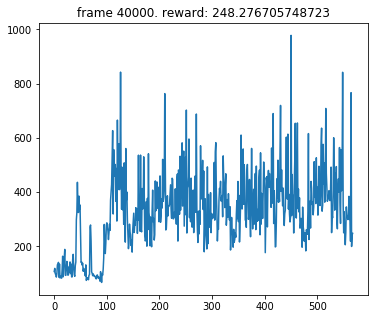

In [18]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_net.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

## Visualize Trained Algorithm

In [21]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(anim)

Creating offscreen glfw


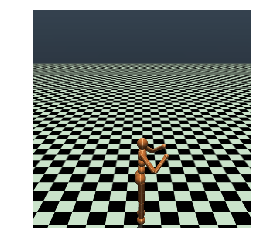

In [25]:
env = gym.make("Humanoid-v2")

# Run a demo of the environment
state = env.reset()
cum_reward = 0
frames = []
for t in range(50000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = policy_net.get_action(state)
    state, reward, done, info = env.step(action.detach())
    if done:
        break
env.close()
display_frames_as_gif(frames)